In [165]:
import numpy as np
import scipy.sparse as sp
import torch
from sklearn.preprocessing import LabelBinarizer
import time

In [166]:
"""
load data from data set.

return: adjacency matrix(sparse matrix), features(sparse) and labels
"""
def load_data(path):
    cat_data = np.load(path)
    n = len(cat_data["target"])
    x = np.zeros((n, n), dtype=np.float32)
    for i in cat_data["edges"]:
        x[i[0]][i[1]] = 1
    return sp.csr_matrix(x), sp.csr_matrix(cat_data["features"], dtype=np.float32), cat_data["target"]


"""
normalize the data.

Param: adjacency matrix.
return: normalized adjacency matrix.
"""
def normalize_adj(adjacency):
    adjacency += sp.eye(adjacency.shape[0])
    degree = np.array(adjacency.sum(1))
    d_hat = sp.diags(np.power(degree, -0.5).flatten())
    return d_hat.dot(adjacency).dot(d_hat).tocoo()


"""
normalize features.

Param: features.
return: normalized features.
"""
def normalize_features(features):
    return features / features.sum(1)

In [167]:
PATH = "F:\\3710report\\facebook.npz"

adjacency, features, labels = load_data(PATH)

#encoded the label to one hot
onehot = LabelBinarizer()
labels = onehot.fit_transform(labels)

#normalize adjacency matrix and features
adjacency = normalize_adj(adjacency)
features = normalize_features(features)

#transform to tensor.
features = torch.FloatTensor(np.array(features))
labels = torch.LongTensor(np.where(labels)[1])

print(adjacency)
print(features)
print(labels)

  (0, 0)	0.5000000000000001
  (0, 18427)	0.09805806756909202
  (1, 1)	0.028571428571428567
  (1, 2812)	0.02492223931396134
  (1, 4987)	0.016903085094570332
  (1, 5228)	0.020965696734438363
  (1, 5307)	0.015240998561973751
  (1, 5755)	0.020348923188911988
  (1, 6829)	0.031943828249996996
  (1, 7136)	0.033149677206589796
  (1, 8049)	0.012135707849456652
  (1, 8533)	0.027788500718836418
  (1, 8894)	0.023218173010628604
  (1, 9934)	0.019920476822239894
  (1, 10281)	0.04517539514526256
  (1, 10379)	0.007805119495830757
  (1, 10554)	0.02238868314198225
  (1, 11557)	0.019783564706223267
  (1, 12305)	0.020498001542269693
  (1, 13737)	0.021295885499998
  (1, 14344)	0.02366905341655754
  (1, 15026)	0.02577696311132335
  (1, 15785)	0.013894250359418209
  (1, 16260)	0.03253000243161777
  (1, 16590)	0.018018749253911177
  :	:
  (22467, 5339)	0.038235955645093626
  (22467, 6181)	0.04233337566673017
  (22467, 8565)	0.03984095364447979
  (22467, 9367)	0.02703690352179376
  (22467, 9986)	0.033671751485

In [168]:
node_number = features.shape[0]

#get train mask, validation mask and test mask. (split the data set)
train_mask = np.zeros(node_number, dtype=bool)
val_mask = np.zeros(node_number, dtype=bool)
test_mask = np.zeros(node_number, dtype=bool)
train_mask[:3000] = True
val_mask[3000:4000] = True
test_mask[4000:5000] = True

In [169]:
"""
Graph convolution network layer.

"""
class GCNLayer(torch.nn.Module):
    """
    initialiser of graph convolution layer.
    
    Params:
    input_dim: input dimension of this layer.
    out_dim: output dimension of this layer.
    use_bias: if use bias(optional).
    
    """
    def __init__(self, input_dim, output_dim, use_bias=True):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = torch.nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = torch.nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    """
    initialise parameters.
    """
    def reset_parameters(self):
        #initialise weight.
        torch.nn.init.kaiming_uniform_(self.weight)
        if self.use_bias:
            torch.nn.init.zeros_(self.bias)

    """
    Define computation performed at every call.
    
    Params:
    adjacency: adjacency matrix.
    input_feature: features of every data in dataset.
    """
    def forward(self, adjacency, input_feature):
        device = "cpu"
        support = torch.mm(input_feature, self.weight.to(device))
        # adjacency is sparse matrix so it need torch.sparse.mm instead of torch.mm
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias.to(device)
        return output

In [170]:
"""
Graph convolution network.
Consist of two gcn layers.
"""
class GCN(torch.nn.Module):
    """
    initialise the gcn model.
    Param:
    input_dim: the input dimension of the features.(128 dimensions of facebook dataset.)
    """
    def __init__(self, input_dim=128):
        super(GCN, self).__init__()
        self.gcn_layer1 = GCNLayer(input_dim, 16)
        
        #4 classes in this dataset.
        self.gcn_layer2 = GCNLayer(16, 4)
        
        
    """
    Define computation performed at every call.
    
    Params:
    adjacency: adjacency matrix.
    feature: features of every data in dataset.
    """
    def forward(self, adjacency, feature):
        hidden = torch.nn.functional.relu(self.gcn_layer1(adjacency, feature))
        output = self.gcn_layer2(adjacency, hidden)
        return output

In [171]:
learning_rate = 0.1 # learning rate.
weight_decay = 5e-4 # weight decay to prevent overfitting.
epochs = 200 # we train 200 epochs.

device = "cpu" # we don't have gpu so we use cpu as our device.
model = GCN().to(device) # Initialise the model and load it to device.

# initialise loss function and optimizer.
# we use CrossEntropyLoss as our loss function and adam as our optimizer/
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# load features and labels to device.
tensor_features = features.to(device)
tensor_labels = labels.to(device)

# Transform masks to pytorch tensor and load them to cpu.
tensor_train_mask = torch.from_numpy(train_mask).to(device)
tensor_val_mask = torch.from_numpy(val_mask).to(device)
tensor_test_mask = torch.from_numpy(test_mask).to(device)

# initialise the adjacency matrix tensor and load it to cpu.
indices = torch.from_numpy(np.asarray([adjacency.row, adjacency.col]).astype('int64')).long()
values = torch.from_numpy(adjacency.data.astype(np.float32))
# we have 22470 data in this dataset.
tensor_adjacency = torch.sparse.FloatTensor(indices, values, (22470, 22470)).to(device)

In [172]:
"""
test the model to know the accuarcy on corresponding mask.
"""
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_features)
        test_mask_logits = logits[mask]
        predict_labels = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_labels, tensor_labels[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_labels[mask].cpu().numpy()

In [173]:
"""
main training process.
"""
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_labels = tensor_labels[tensor_train_mask]
    
    for epoch in range(1, epochs + 1):
        
        start = time.time()
        
        logits = model(tensor_adjacency, tensor_features) # Forward propagation.
        train_mask_logits = logits[tensor_train_mask] # Only nodes on training set are selected for supervision.
        loss_val = loss(train_mask_logits, train_labels) # Calculate loss value.
        optimizer.zero_grad()
        loss_val.backward() # Back propagation to calculate the gradient of parameters.
        optimizer.step() # Use optimizer to update gradient.
        
        train_acc, _, _ = test(tensor_train_mask) # Calculate the accuracy on the training set.
        val_acc, _, _ = test(tensor_val_mask) # Calculate the accuracy on the validation set.
        
        """
        Record the changes of loss value and accuracy in 
        the training process for visualization.
        """
        loss_history.append(loss_val.item()) 
        val_acc_history.append(val_acc.item())
        # print training result every 10 epochs.
        print("Epoch %3d/%d: Loss %.4f, Train_accuracy %.4f, Validation_accuracy %.4f, Time %.4f"%(
                epoch, epochs, loss_val.item(), train_acc.item(), val_acc.item(), time.time() - start))

In [174]:
train()

Epoch   1/200: Loss 1.4825, Train_accuracy 0.3350, Validation_accuracy 0.3070, Time 0.1251
Epoch   2/200: Loss 1.3448, Train_accuracy 0.3703, Validation_accuracy 0.3660, Time 0.1271
Epoch   3/200: Loss 1.3166, Train_accuracy 0.4730, Validation_accuracy 0.4380, Time 0.1421
Epoch   4/200: Loss 1.2728, Train_accuracy 0.4930, Validation_accuracy 0.4630, Time 0.1421
Epoch   5/200: Loss 1.2348, Train_accuracy 0.5567, Validation_accuracy 0.5480, Time 0.1421
Epoch   6/200: Loss 1.1916, Train_accuracy 0.6397, Validation_accuracy 0.6280, Time 0.1411
Epoch   7/200: Loss 1.1470, Train_accuracy 0.6637, Validation_accuracy 0.6590, Time 0.1411
Epoch   8/200: Loss 1.0929, Train_accuracy 0.6927, Validation_accuracy 0.6970, Time 0.1351
Epoch   9/200: Loss 1.0360, Train_accuracy 0.6933, Validation_accuracy 0.6980, Time 0.1351
Epoch  10/200: Loss 0.9861, Train_accuracy 0.6977, Validation_accuracy 0.7040, Time 0.1351
Epoch  11/200: Loss 0.9355, Train_accuracy 0.7040, Validation_accuracy 0.7120, Time 0.1481

Epoch  92/200: Loss 0.3277, Train_accuracy 0.9083, Validation_accuracy 0.8860, Time 0.1361
Epoch  93/200: Loss 0.3230, Train_accuracy 0.9107, Validation_accuracy 0.8930, Time 0.1461
Epoch  94/200: Loss 0.3204, Train_accuracy 0.9053, Validation_accuracy 0.8760, Time 0.1471
Epoch  95/200: Loss 0.3238, Train_accuracy 0.9107, Validation_accuracy 0.8890, Time 0.1481
Epoch  96/200: Loss 0.3236, Train_accuracy 0.9100, Validation_accuracy 0.8910, Time 0.1451
Epoch  97/200: Loss 0.3200, Train_accuracy 0.9113, Validation_accuracy 0.8830, Time 0.1531
Epoch  98/200: Loss 0.3212, Train_accuracy 0.9130, Validation_accuracy 0.8890, Time 0.1451
Epoch  99/200: Loss 0.3232, Train_accuracy 0.9113, Validation_accuracy 0.8800, Time 0.1431
Epoch 100/200: Loss 0.3207, Train_accuracy 0.9157, Validation_accuracy 0.8880, Time 0.1451
Epoch 101/200: Loss 0.3192, Train_accuracy 0.9110, Validation_accuracy 0.8880, Time 0.1381
Epoch 102/200: Loss 0.3210, Train_accuracy 0.9090, Validation_accuracy 0.8770, Time 0.1311

Epoch 183/200: Loss 0.3162, Train_accuracy 0.9047, Validation_accuracy 0.8710, Time 0.1401
Epoch 184/200: Loss 0.3200, Train_accuracy 0.9097, Validation_accuracy 0.8860, Time 0.1411
Epoch 185/200: Loss 0.3210, Train_accuracy 0.9083, Validation_accuracy 0.8750, Time 0.1431
Epoch 186/200: Loss 0.3179, Train_accuracy 0.9167, Validation_accuracy 0.8880, Time 0.1331
Epoch 187/200: Loss 0.3151, Train_accuracy 0.9150, Validation_accuracy 0.8860, Time 0.1491
Epoch 188/200: Loss 0.3162, Train_accuracy 0.9083, Validation_accuracy 0.8750, Time 0.1491
Epoch 189/200: Loss 0.3189, Train_accuracy 0.9107, Validation_accuracy 0.8890, Time 0.1551
Epoch 190/200: Loss 0.3189, Train_accuracy 0.9117, Validation_accuracy 0.8830, Time 0.1331
Epoch 191/200: Loss 0.3165, Train_accuracy 0.9177, Validation_accuracy 0.8890, Time 0.1551
Epoch 192/200: Loss 0.3153, Train_accuracy 0.9143, Validation_accuracy 0.8890, Time 0.1571
Epoch 193/200: Loss 0.3169, Train_accuracy 0.9103, Validation_accuracy 0.8740, Time 0.1491

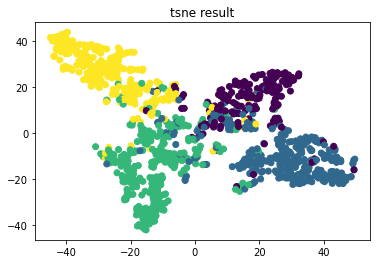

In [178]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
test_accuracy, test_data, test_labels = test(tensor_test_mask)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
embs = tsne.fit_transform(test_data)
plt.title('tsne result')
plt.scatter(embs[:,0], embs[:,1], marker='o', c=test_labels)
plt.savefig("GCN_tsne.png")